In [1]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, ExtendedDataset, evaluate_on_test, init_weights, save_obj, load_obj, remove_nan

In [3]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0], parse_dates=True)

In [4]:
# start from 1960
full.drop(columns=['A191RL1Q225SBEA'], inplace=True)
full = full.loc["1960-01-01":]
full = remove_nan(full)
print(full.shape)

INTDSRUSM193N
ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
GS20
MCOILWTICO
TCU
TOTALSA
(709, 21)


In [26]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, lags, hidden_size):
        super(LSTMNet, self).__init__()
        self.lags = lags
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # input_size should match that in forward method
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, 3)
        
    def forward(self, x):
        # input to lstm layer is (seq_len, batch, input_size)
        x, (hn, cn) = self.lstm(x.view(self.lags, 1, self.input_size))
        # we only care about the output of the hidden
        hn = F.relu(self.fc1(hn))
        hn = F.relu(self.fc2(hn))
        hn = self.fc3(hn)
        return hn

In [28]:
trainer = TrainHelper(percent = 0.99, manual = 5000, print_every=1000)

PATH = "./LSTM Extended Two Layer/"

def train_times(times, trainer, net, criterion, optimizer, window):
    
    losses = []

    # train ten times, find best loss
    for i in range(times):
        net.apply(init_weights)
        print("Training %d time" % i)
        loss = trainer.train_window(net, criterion, optimizer, window)
        torch.save(net.state_dict(), PATH + "lag" + str(net.lags) + "hidden" + str(net.hidden_size) + "_" + str(i) + ".pt")
        losses.append(loss)
        
    return losses

In [7]:
length = len(full)
val_start = round(length * 0.8)
test_start = round(length * 0.9)    

In [8]:
losses = {}

In [29]:
hiddens = [30]

for lags in range(1, 15):
    data = ExtendedDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

    # subtract by lags to ensure same training sets
    trainset = Subset(data, [i for i in range(val_start - 1 - lags)])
    valset = Subset(data, [i for i in range(val_start - lags, test_start - 1 - lags)])

    trainloader = DataLoader(trainset, batch_size=1, shuffle=False, sampler=SequentialSampler(trainset))
    validationloader = DataLoader(valset, batch_size=1, shuffle=False, sampler=SequentialSampler(valset))

    window = Window(trainloader, validationloader)
    
    for hidden_size in hiddens:
        print("Training new net, %d lags %d hidden" % (lags, hidden_size))

        net = LSTMNet(lags=lags, hidden_size=hidden_size, input_size = full.shape[1])
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        loss = train_times(10, trainer, net, criterion, optimizer, window)
        print(loss)
        losses[str(lags) + "-" + str(hidden_size)] = loss
    

Training new net, 1 lags 30 hidden
Training 0 time
[epoch: 1] train loss: 0.820, val loss: 1.622
Finished window, trained for 60 epochs, loss: 0.472
Training 1 time
[epoch: 1] train loss: 0.691, val loss: 1.888
Finished window, trained for 48 epochs, loss: 0.521
Training 2 time
[epoch: 1] train loss: 0.732, val loss: 1.759
Finished window, trained for 39 epochs, loss: 0.576
Training 3 time
[epoch: 1] train loss: 0.750, val loss: 1.670
Finished window, trained for 39 epochs, loss: 0.458
Training 4 time
[epoch: 1] train loss: 0.804, val loss: 1.631
Finished window, trained for 32 epochs, loss: 0.540
Training 5 time
[epoch: 1] train loss: 0.749, val loss: 1.605
Finished window, trained for 32 epochs, loss: 0.518
Training 6 time
[epoch: 1] train loss: 0.679, val loss: 1.537
Finished window, trained for 28 epochs, loss: 0.473
Training 7 time
[epoch: 1] train loss: 0.589, val loss: 1.587
Finished window, trained for 31 epochs, loss: 0.552
Training 8 time
[epoch: 1] train loss: 0.741, val los

KeyboardInterrupt: 

In [30]:
for k, v in losses.items():
    print(k)
    best_net_index = np.argmin(v)
    print("%.4f" % v[best_net_index])
    print("(%.4f)" % get_average(v))


1-30
0.4576
(0.5233)
2-30
0.4788
(0.6042)
3-30
0.5311
(0.6996)
4-30
0.5964
(0.6691)
5-30
0.8746
(0.9835)
6-30
0.6935
(0.7903)
7-30
0.7624
(0.9948)


In [39]:
best_loss = []
avg_loss = []

for k, v in losses.items():
    best_net_index = np.argmin(v)
    best_loss.append(v[best_net_index])
    avg_loss.append(get_average(v))

Text(0, 0.5, 'Final Validation Loss')

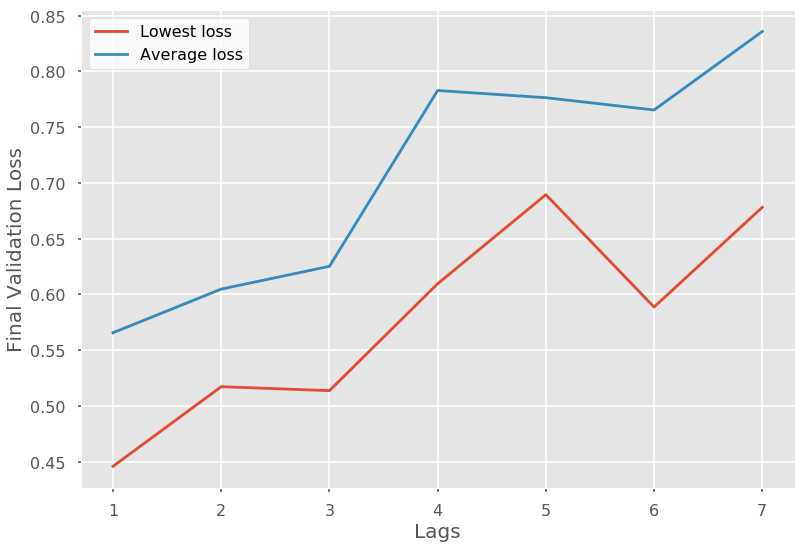

In [40]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(best_loss) + 1)], best_loss)
plt.plot([i for i in range(1, len(best_loss) + 1)], avg_loss)

plt.xticks([1, 2, 3, 4, 5, 6, 7])

plt.legend(("Lowest loss", "Average loss"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
# plt.savefig('../Figs/lags_lstm_extended.png', bbox_inches='tight')

In [37]:
losses = load_obj("LSTM_Extended")

In [38]:
losses

{'1-30': [0.44583486556962487,
  0.47184996651762745,
  0.5346428672079041,
  0.5294792906389505,
  0.5520047917174885,
  0.6542839439441671,
  0.5491517733045232,
  0.5725536771883656,
  0.7078365168833572,
  0.6390173931969219],
 '2-30': [0.599816823152027,
  0.5835826920345425,
  0.5172857537011927,
  0.6156503968805608,
  0.562299931421876,
  0.6595122855334055,
  0.5852109616029165,
  0.6210208182677716,
  0.6942561007636999,
  0.6093750627667066],
 '3-30': [0.6340188606772461,
  0.5966249641319293,
  0.542091578460254,
  0.6206064762481089,
  0.5999774477976774,
  0.7725633384349447,
  0.6640739297627338,
  0.6362502952738266,
  0.6722648121106128,
  0.5137283454848719],
 '4-30': [0.6096014894367684,
  0.764612089583118,
  0.6936081785642143,
  0.8657708658936567,
  0.7704463580778489,
  0.6842330087530648,
  0.8486908680803719,
  0.8722966131576825,
  0.8604579640330657,
  0.8594351884687231],
 '5-30': [0.8633497971797451,
  0.7569540130994504,
  0.827996887493923,
  0.893271464